# DATA EDA 분석 1. (2020.11.25(수))

* 라이브러리 불러오기

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from tensorflow.keras.utils import plot_model

from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.font_manager as fm
path = 'data/font/NanumGothic-ExtraBold.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

 * 데이터 불러오기

In [104]:
cks_dtype = {'clnt_id':'int64','sess_id':'int64','hit_seq':'int64','action_type':'int64','biz_unit':'category','sess_dt':'object','hit_tm':'object',
             'hit_pss_tm':'int64','trans_id':'float64','sech_kwd':'object','tot_pag_view_ct':'float64','tot_sess_hr_v':'float64','trfc_src':'category',
             'dvc_ctg_nm':'object','pd_c':'object','de_dt':'object','de_tm':'object','buy_am':'int64','buy_ct':'int64','clnt_gender':'category'}

raw_data1_Online_Act = pd.read_csv('./data/online_01.csv', dtype=cks_dtype)
raw_data2_Trade_Inform = pd.read_csv('./data/trade_01.csv', dtype=cks_dtype)
raw_data3_Demog = pd.read_csv('./data/customer_01.csv', dtype=cks_dtype)
raw_data4_Item_Class = pd.read_csv('./data/item_01.csv', dtype=cks_dtype)

## 1. 온라인 행동 데이터 확인

In [105]:
raw_data1_Online_Act.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app


* 1-1. clnt_id : 고객 고유 식별 ID
* 1-2. sess_id : 세션이 시작될 때 부여되는 순번ID
* 1-3. hit_seq : 조회 순서를 알 수 있도록 한 일련번호
* 1-4. action_type : 온라인 행동 유형
 (0:검색 / 1:제품 목록 / 2:제품 세부정보 보기 / 3: 장바구니 제품 추가 / 4:장바구니 제품 삭제 / 5:결제 시도 / 6:구매완료 / 7:구매환불 / 8:결재 옵션)
* 1-5. biz_unit(업종단위) : 온라인 및 오프라인 이용코드
* 1-6. sess_dt : 세션 일자(년월일)
* 1-7. hit_tm : 조회 시각(HH:MM)
* 1-8. hit_pss_tm : 조회 경과시간(세션의 시작 부터 조회까지 걸리시간(밀리초) / 첫번째 조회는 0으로 설정)
* 1-9. Trans_ID : 거래 ID(구매내역을 고유 식별할 수 있는 ID)
* 1-10. sech_kwd : 고객이 검색한 키워드
* 1-11. tot_pag_view_ct : 총 페이지 조회 건수(세션 내에 총 페이지(화면) 뷰 수)
* 1-12. tot_sess_hr_v : 총 세션 시간 값
* 1-13. trfc_src : 유입 채널
 (DIRECT / PUSH / WEBSITE / PORTAL_1 / PORTAL_2 / PORTAL_3 / unknown)
* 1-14. dvc_ctg_nm : 기기 유형 (mobile_web / mobile_app / PC)

In [106]:
raw_data1_Online_Act.shape

(3196362, 14)

 * 행 수(데이터 갯수) : 319만 개
 * 열 수(데이터 종류) : 14개

### 1-1. clnt_Id : 고객 고유 식별 ID

 * 2-1, 3-1 clnt_id와 동일한 의미입니다.

 * 고객 ID는 몇 개나 있는가?? => 7만명의 고객 ID 보유
     * 1. 온라인 행동 데이터 내 고객ID 갯수 : 72399개
     * 2. 거래 정보 데이터 내 고객ID 갯수 :11284개
     * 3. 사용자 demog 정보 내 고객ID 갯수 : 72399개

In [107]:
raw_data1_Online_Act['clnt_id'].nunique()

72399

 * 고객ID 별로 온라인 행동 데이터는 몇 건이 있는지? => 최대 6600건, 최소 1건

In [108]:
raw_data1_Online_Act['clnt_id'].value_counts()

61252    6663
57915    5317
48181    4867
62445    4709
49906    4131
         ... 
22838       1
24306       1
26928       1
64305       1
49714       1
Name: clnt_id, Length: 72399, dtype: int64

 * 결측치 갯수 확인 => 없음

In [109]:
raw_data1_Online_Act['clnt_id'].isna().sum()

0

### 1-2. sess_id : 세션이 시작될 때 부여되는 순번ID

 * 세션 ID는 몇 개나 있는가?? => 550개
 
     * 고객ID 7만명에 대한 온라인 행동이 있는데, 세션은 550개 밖에 안된다??
         * 세션ID에 결측치 많을 것을 예상 => 결측치 없음(아래 참조)
         * 같은 세션ID에 서로다른 고객ID 존재 예상

In [110]:
raw_data1_Online_Act['sess_id'].nunique()

550

 * 세션ID 별로 온라인 행동 데이터는 몇 건이 있는지? => 최대 51만 건, 최소 1건

In [111]:
raw_data1_Online_Act['sess_id'].value_counts()

1      517024
2      279811
3      203178
4      155479
5      130391
        ...  
527         1
516         1
524         1
518         1
514         1
Name: sess_id, Length: 550, dtype: int64

 * 결측치 갯수 확인 => 없음

In [112]:
raw_data1_Online_Act['sess_id'].isna().sum()

0

 * 같은 세선ID(=1) 내에 서로 다른 고객 ID 있는지 확인
     * 세션ID == 1 에서만 약 7만개의 고객 ID가 있음
     * 서로 다른 고객에게 유일하게 세션ID 부여되지 않는다는 사실을 알게됨

In [113]:
sess_is_1 = raw_data1_Online_Act['clnt_id'][raw_data1_Online_Act['sess_id']==1]

In [114]:
sess_is_1.head()

0     1
1     1
2     1
10    2
11    2
Name: clnt_id, dtype: int64

In [115]:
sess_is_1.nunique()

72399

### 1-3. hit_seq : 조회 순서를 알 수 있도록 한 일련번호

 * 조회 일련번호는 몇 개나 있는가?? => 357개

In [116]:
raw_data1_Online_Act['hit_seq'].nunique()

357

 * 조회일련번호 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 36만 건 , 최소 1건

In [117]:
raw_data1_Online_Act['hit_seq'].value_counts()

1      367149
2      246633
3      198580
4      167819
5      143873
        ...  
282         1
281         1
280         1
279         1
357         1
Name: hit_seq, Length: 357, dtype: int64

 * 결측치 갯수 확인 => 없음

In [118]:
raw_data1_Online_Act['hit_seq'].isna().sum()

0

- sess_dt가 변화하는 경우 sess_id가 함께 바뀜
- sess_dt가 같은 경우에는 hit_tm이 변화해도 sess_id는 그대로 유지됨
- hit_tm이 변화하면 hit_seq가 변화함
- hit_pss_tm로 미루어보아 행동 순서에 따라 hit_seq가 생성됨

따라서 clnt가 꽤 긴 시간텀을 두고 쇼핑을 시작하는 경우 새로운 sess_id가 부여되며, 특정 sess_id 내에서 hit_seq를 통해 순차적인 행동을 구분할 수 있는 것으로 보입니다.

#####  clnt_id, sess_id, hit_seq가 Online_Act table의 Primary key column

In [119]:
raw_data1_Online_Act.loc[raw_data1_Online_Act['clnt_id']==30605, 
                         ['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'sess_dt', 'hit_tm', 'hit_pss_tm']].sort_values(by=['sess_id', 'hit_seq'])[:30]

,clnt_id,sess_id,hit_seq,action_type,sess_dt,hit_tm,hit_pss_tm
1281360,30605,1,1,1,20190712,22:53,186078
1281361,30605,1,2,2,20190712,22:53,187210
1281362,30605,2,1,1,20190717,17:25,92373
1281363,30605,2,2,1,20190717,17:25,92526
1281364,30605,2,3,2,20190717,17:25,93746
1281365,30605,2,4,3,20190717,17:25,102794
1281366,30605,2,5,5,20190717,17:25,105745
1281367,30605,2,6,4,20190717,17:25,110902
1281368,30605,2,7,5,20190717,17:25,111604
1281369,30605,2,8,4,20190717,17:25,114763


(18087.0, 18109.0)

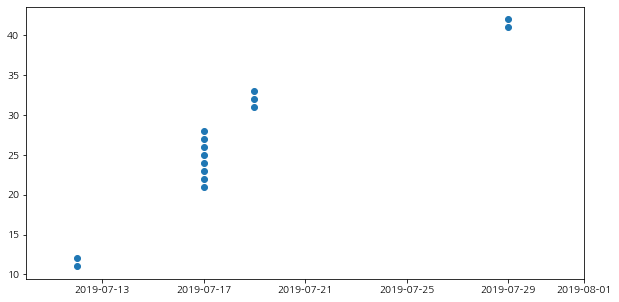

In [120]:
from datetime import datetime, date # 날짜형 자료형을 다루는 라이브러리
temp = raw_data1_Online_Act[(raw_data1_Online_Act['clnt_id']==30605) & (raw_data1_Online_Act['sess_id']<5)].copy() 
    # sess_id*10+hit_seq 계산을 위해 hit_seq<10인 sess_id만 고려함. 
temp.sess_dt = pd.to_datetime(temp.sess_dt, format='%Y%m%d') # sess_dt col의 자료형 변경

plt.figure(figsize=(10, 5)) # plot size 조절
plt.scatter(temp.sess_dt, temp.sess_id * 10 + temp.hit_seq) # scatter plot 작성 / sess_id, hit_seq range에 맞는 y축 연산 필요함.
plt.xlim([date(2019,7,10), date(2019,8,1)]) # x축 조정

날짜가 변하면 sess_dt(y축 10의자리)가 함께 바뀌고 hit_seq(y축 1의자리)는 차례로 증가하는 것을 확인하실 수 있습니다.

### 1-4. action_type : 온라인 행동 유형
 *  0:검색 / 1:제품 목록 / 2:제품 세부정보 보기 / 3: 장바구니 제품 추가 / 4:장바구니 제품 삭제 
 * 5:결제 시도 / 6:구매완료 / 7:구매환불 / 8:결재 옵션

 * 온라인 행동 유형는 몇 개나 있는가?? => 8개
 
     * class 갯수는 9개이므로 존재하지 않는 행동 하나 있음
         * '8. 결재 옵션'은 데이터 존재하지 않음(하단 확인)

In [121]:
raw_data1_Online_Act['action_type'].nunique()


8

 * 온라인 행동 유형 별 온라인 행동데이터는 몇 건이 있는지? => 최대 75만 건 , 최소 5600건
     * 제일 많은 행동은 약 75만 건의 '5. 결제 시도' 이며
     * 제일 적은 행동은 약 5600건의 '7. 구매 환불' 임
     * '8. 결재 옵션'은 데이터 존제하지 않음이 확인됨

In [122]:
raw_data1_Online_Act['action_type'].value_counts()

5    750530
2    655266
0    651638
3    596765
1    307998
4    172240
6     56249
7      5676
Name: action_type, dtype: int64

 * 결측치 갯수 확인 => 없음

In [123]:
raw_data1_Online_Act['action_type'].isna().sum()

0

#### 온라인 행동 유형 시각화

<function matplotlib.pyplot.show(close=None, block=None)>

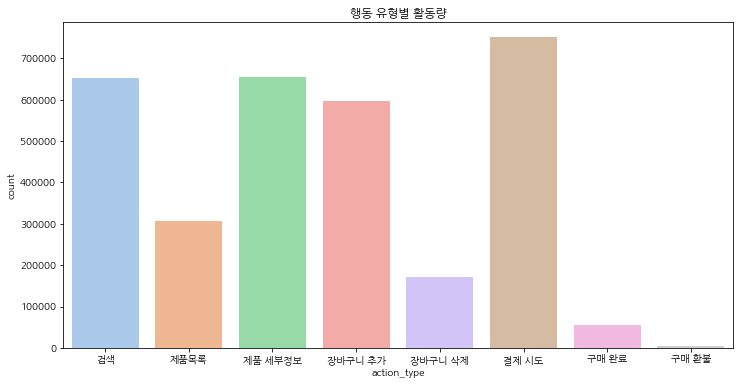

In [124]:
title = '행동 유형별 활동량'
plt.figure(figsize=(12,6))
sns.countplot(x= 'action_type', data=raw_data1_Online_Act, palette="pastel")
action_labels = ['검색','제품목록','제품 세부정보','장바구니 추가','장바구니 삭제','결제 시도','구매 완료','구매 환불']
plt.xticks(ticks=np.arange(8), labels = action_labels)
plt.title(title)
plt.show

결제 시도에서 구매 완료까지 가는 인원이 현저히 줄어들었음을 확인 할 수 있습니다.

1. 결제 중복 시도가 3회 이상인 고객의 비율
2. 결제 시도를 했으나 구매 완료까지 가지 않은 고객의 비율

#### 1-4-1. 결제 중복 시도 확인
다른 ID인지, 다른 날짜인지 고려할 필요가 있습니다. 

In [125]:
def OverlabAct(data, k):
    temp = 0
    overlab = []
    for i, row in tqdm(data.iterrows(), total=data.shape[0]):
        # act가 k 이면, +1한다. 
        if row['action_type'] == 5:
            temp = temp +1
        # act가 달라지면 중복 횟수만큼 저장하게된다. 
        else:
            overlab.append(temp)
            temp = 0
    return np.array(overlab)

### 1-5. biz_unit(업종단위) : 온라인 및 오프라인 이용코드

 * 업종단위는 몇 개나 있는가?? => 3개
     * 1. 온라인 행동 데이터 내 업종단위 갯수 : 3개 (A01, A02, A03)
     * 2. 거래 정보 데이터 내 업종단위 갯수 : 6개 (A01, A02, A03, B01, B02, B03)

In [127]:
raw_data1_Online_Act['biz_unit'].nunique()

3

 * 업종단위 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 23만 건 , 최소 19만건

<AxesSubplot:xlabel='biz_unit', ylabel='count'>

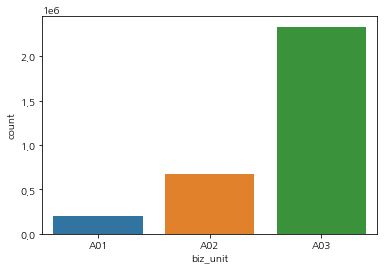

In [128]:
sns.countplot(raw_data1_Online_Act['biz_unit'])

In [129]:
raw_data1_Online_Act['biz_unit'].value_counts()

A03    2331437
A02     668093
A01     196832
Name: biz_unit, dtype: int64

 * 결측치 갯수 확인 => 없음

In [130]:
raw_data1_Online_Act['biz_unit'].isna().sum()

0

#### 업종 단위별 온라인 행동데이터 분포

<AxesSubplot:xlabel='biz_unit', ylabel='count'>

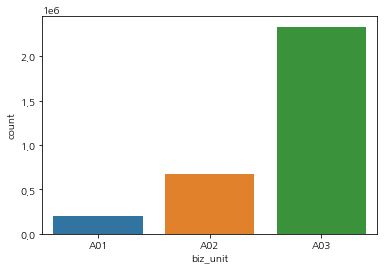

In [131]:
sns.countplot(raw_data1_Online_Act['biz_unit'])

온라인 업종 별로 인원수 차이가 큽니다.  
왜 이렇게 업종별로 데이터 차이가 큰 것인지 궁금합니다.  
중복 수가 많다는 가정을 하고, 유니크한 매장별 고객수를 뽑아보겠습니다. 

In [132]:
test = pd.DataFrame(raw_data2_Trade_Inform.groupby('clnt_id')['biz_unit'].apply(lambda x: ','.join(set(x))))

<AxesSubplot:xlabel='biz_unit', ylabel='count'>

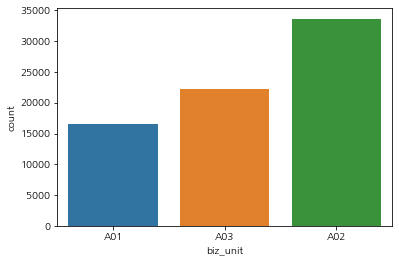

In [133]:
uniq_clnt = pd.DataFrame(raw_data1_Online_Act.groupby('clnt_id')['biz_unit'].apply(lambda x: ','.join(set(x))))
sns.countplot(uniq_clnt['biz_unit'])

한편 고객과 매장을 그룹으로 묶어서 중복을 제거해보니,  
실질적인 고객 수는 A03에 더 많았습니다.

**의견** 
- A03 매장에서는 한 고객이 많이 구매했을 수도 있다.  
- 매장 별로 경향성이 있는 지 파악을 해보는 게 중요하다.  
- 이 자체가 영향을 끼치는 지 명확하지 않다.  
- 유의미 하지 않으면 밸런싱 할 필요가 없어보인다. 

이 부분에 대해서 두가지 더 살펴보았습니다. 
1. 각 매장별로 행동 유형에 대한 중복 확인
2. 각 매장별 행동 그래프

#### 1-5-1. 각 매장별 행동 유형에 대한 중복 확인

In [134]:
online_A03 = raw_data1_Online_Act[raw_data1_Online_Act['biz_unit']=='A03']
online_A02 = raw_data1_Online_Act[raw_data1_Online_Act['biz_unit']=='A02']
online_A01 = raw_data1_Online_Act[raw_data1_Online_Act['biz_unit']=='A01']

np_over_A03 = OverlabAct(online_A03, 5)
np_over_A02 = OverlabAct(online_A02, 5)
np_over_A01 = OverlabAct(online_A01, 5)

100%|██████████| 196832/196832 [00:10<00:00, 19262.05it/s]


In [135]:
print('A03에서 3번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A03[np_over_A03>=3].sum()/np_over_A03.sum(),3)*100, '%')
print('A02에서 3번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A02[np_over_A02>=3].sum()/np_over_A02.sum(),3)*100, '%')
print('A01에서 3번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A01[np_over_A01>=3].sum()/np_over_A01.sum(),3)*100, '%')

A03에서 3번 이상 연속으로 결제 시도가 중복된 비율: 52.6 %
A02에서 3번 이상 연속으로 결제 시도가 중복된 비율: 33.1 %
A01에서 3번 이상 연속으로 결제 시도가 중복된 비율: nan %


In [136]:
print('A03에서 2번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A03[np_over_A03>=2].sum()/np_over_A03.sum(),4)*100, '%')
print('A02에서 2번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A02[np_over_A02>=2].sum()/np_over_A02.sum(),4)*100, '%')
print('A01에서 2번 이상 연속으로 결제 시도가 중복된 비율:', round(np_over_A01[np_over_A01>=2].sum()/np_over_A01.sum(),4)*100, '%')

A03에서 2번 이상 연속으로 결제 시도가 중복된 비율: 67.81 %
A02에서 2번 이상 연속으로 결제 시도가 중복된 비율: 72.5 %
A01에서 2번 이상 연속으로 결제 시도가 중복된 비율: nan %


2번 이상 연속과 3번 이상 연속인 경우 달라지는 모습을 확인 할 수 있습니다.

#### 1-5-2. 각 매장별 행동 그래프

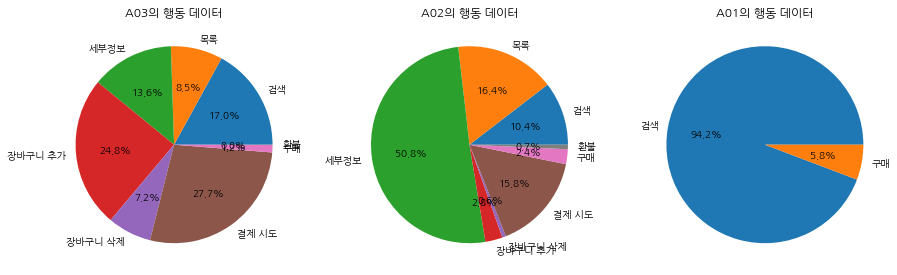

In [137]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
label_3 = ['검색', '목록', '세부정보', '장바구니 추가', '장바구니 삭제', '결제 시도', '구매', '환불']
label_2 = ['검색', '목록', '세부정보', '장바구니 추가', '장바구니 삭제', '결제 시도', '구매', '환불']
label_1 = ['검색', '구매']

axs[0].pie(online_A03['action_type'].value_counts().sort_index(), autopct='%0.1f%%', labels=label_3)
axs[0].set_title('A03의 행동 데이터')

axs[1].pie(online_A02['action_type'].value_counts().sort_index(), autopct='%0.1f%%', labels=label_2)
axs[1].set_title('A02의 행동 데이터')

axs[2].pie(online_A01['action_type'].value_counts().sort_index(), autopct='%0.1f%%', labels=label_1)
axs[2].set_title('A01의 행동 데이터')

plt.show()

각 매장별 행동 데이터에 대한 분포도 다릅니다.  
A03의 경우 결제 시도가 가장 많긴 하지만 대체로 골고루 분포가 되어 있습니다.  
A02의 경우 세부정보가 과반수 넘게 분포되어 있습니다.  
A01의 경우 검색과 구매 데이터만 있습니다. 

### 1-6. sess_dt : 세션 일자(년월일)

 * 세션 일자는 몇 개나 있는가?? => 92개
     * 3달치 데이터가 날짜마다 있을 것으로 예상
         * 7,8,9월 일자 = 31 + 31 + 30 = 92

In [138]:
raw_data1_Online_Act['sess_dt'].nunique()

92

 * 세션 일자 별로 온라인 행동데이터는 몇 건이 있는가? => 최대 5.2만 건 , 최소 1.1만건

In [139]:
raw_data1_Online_Act['sess_dt'].value_counts()

20190708    52860
20190703    47333
20190729    46363
20190905    44881
20190918    43647
            ...  
20190811    24115
20190831    23355
20190915    23261
20190912    19337
20190913    11880
Name: sess_dt, Length: 92, dtype: int64

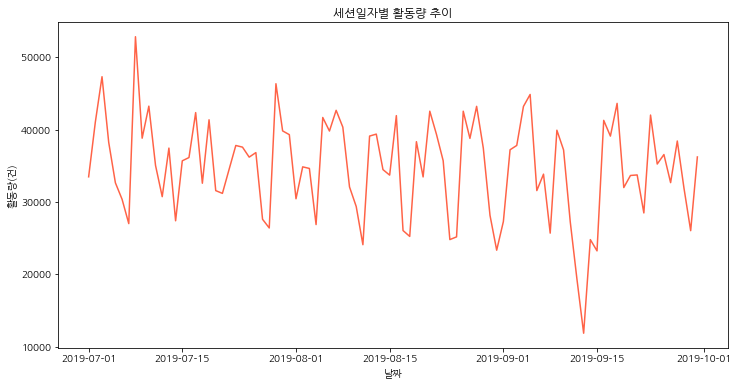

In [140]:
online_act = raw_data1_Online_Act.copy()

online_act['sess_dt'] = pd.to_datetime(online_act['sess_dt'], format='%Y%m%d')
online_act = online_act.groupby('sess_dt').size().to_frame('count').reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=online_act, x='sess_dt', y='count', color='tomato')

plt.title('세션일자별 활동량 추이')
plt.xlabel('날짜'); plt.ylabel('활동량(건)')

plt.show()

 * 결측치 갯수 확인 => 없음

In [141]:
raw_data1_Online_Act['sess_dt'].isna().sum()

0

요일별 상품 품목 시각화 필요

### 1-7. hit_tm : 조회 시각(HH:MM)

 * 조회 시각는 몇 개나 있는가?? => 1440개

In [142]:
raw_data1_Online_Act['hit_tm'].nunique()

1440

 * 조회 시각 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 5500건 , 최소 180건
     * 시간대 별로 데이터 몇 개인지 확인
         * 대략 오전 11시 경이 제일 많고, 새벽 5시 경이 제일 적음
     * 시간대 별로 categorcal하게 전처리 한다면 의미 도출 및 user 그룹 분류에 용이할 것을 판단됨
         - 0\~6시=새벽
         - 6\~12시=오전
         - 12\~18시=오후
         - 18\~24=밤

In [143]:
raw_data1_Online_Act['hit_tm'].value_counts()

11:15    5548
11:10    5504
11:16    5437
11:14    5431
11:13    5401
         ... 
04:58     208
04:53     207
05:01     206
04:57     192
05:06     181
Name: hit_tm, Length: 1440, dtype: int64

 * 결측치 갯수 확인 => 없음

In [144]:
raw_data1_Online_Act['hit_tm'].isna().sum()

0

### 1-8. hit_pss_tm : 조회 경과시간

 * 세션의 시작 부터 조회까지 걸리시간(밀리초) / 첫번째 조회는 0으로 설정

 * 조회 경과시간는 몇 개나 있는가?? => 150만개

In [145]:
raw_data1_Online_Act['hit_pss_tm'].nunique()

1539787

 * 조회 경과시간 별로 온라인 행동데이터는 몇 건이 있는가? => 최대 14900건 , 최소 1건
 
     * 사람이 정상적으로 조회하는데 최소 1초 걸린다고 가정하면, 현재 class 값 0~1000까지는 비정상데이터로 판단할 수 있음
     * 1초 이하의 조회 경과시간 데이터 갯수 : 약 6만개의 데이터는 비정상 데이터
     * 3초로 가정 시 : 8.4만개 데이터 비정상

In [146]:
test = raw_data1_Online_Act['hit_pss_tm'].apply(lambda x: x/60000)

<AxesSubplot:ylabel='hit_pss_tm'>

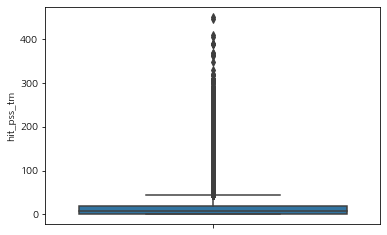

In [147]:
sns.boxplot(y=test.sort_values())

 * 조회 경과시간 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 14900건 , 최소 1건
 
     * 사람이 정상적으로 조회하는데 최소 1초 걸린다고 가정하면, 현재 class 값 0~1000까지는 비정상데이터로 판단할 수 있음
     * 1초 이하의 조회 경과시간 데이터 갯수 : 약 6만개의 데이터는 비정상 데이터
     * 3초로 가정 시 : 8.4만개 데이터 비정상

In [148]:
test.describe()

count    3.196362e+06
mean     1.377734e+01
std      1.791198e+01
min      0.000000e+00
25%      2.045004e+00
50%      7.130358e+00
75%      1.871178e+01
max      4.501214e+02
Name: hit_pss_tm, dtype: float64

평균 13분, 최대값 450분, 하위 75% 18분

In [149]:
raw_data1_Online_Act['hit_pss_tm'].value_counts()

0          14921
1            953
2            818
3            669
4            467
           ...  
3226293        1
3271343        1
3191428        1
3183232        1
3146240        1
Name: hit_pss_tm, Length: 1539787, dtype: int64

In [150]:
len(raw_data1_Online_Act[raw_data1_Online_Act['hit_pss_tm'] <= 1000])

60447

In [151]:
len(raw_data1_Online_Act[raw_data1_Online_Act['hit_pss_tm'] <= 2000])

72662

In [152]:
len(raw_data1_Online_Act[raw_data1_Online_Act['hit_pss_tm'] <= 3000])

84839

 * 결측치 갯수 확인 => 없음

In [153]:
raw_data1_Online_Act['hit_pss_tm'].isna().sum()

0

### 1-9. trans_id : 거래 ID(구매내역을 고유 식별할 수 있는 ID)

 * 거래 ID는 몇 개나 있는가?? => 5만개
 
     * 총 300만의 온라인 행동 중 구매 관련 데이터는 50997개
     * 1. 온라인 행동 데이터 내 거래ID 갯수 : 50997개
     * 2. 거래 정보 데이터 내 거래ID 갯수 : 116440개

In [154]:
raw_data1_Online_Act['trans_id'].nunique()

50997

 * 결측치 갯수 확인 => 3139373 개
     * 온라인 행동 데이터 총 갯수 : 3196362 개

In [155]:
raw_data1_Online_Act['trans_id'].isna().sum()

3139373

 * 거래id가 NaN 이 아닌 데이터들이 갖는 온라인 행동 정보 확인
     * '6. 구매완료'에 대한 거래ID : 51313건
         * 위 action_type 열의 EDA 자료를 확인하면 '6. 구매완료' 갯수는 56249개임
         * 56249-51313 = 4936건에 대한 '6. 구매완료' 데이터는 거래ID 없음
     * '7. 구매환불'에 대한 거래ID : 5676건
         * 위 action_type 열의 EDA 자료를 확인하면 '7. 구매환불' 갯수는 5676개임
             => 갯수 일치
         * '7. 구매환불' 데이터는 모두 거래ID 존재

In [156]:
raw_data1_Online_Act['action_type'][raw_data1_Online_Act['trans_id'].isna() != True].value_counts()

6    51313
7     5676
Name: action_type, dtype: int64

 * 거래ID 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 62건 , 최소 1건

In [157]:
raw_data1_Online_Act['trans_id'].value_counts()

71558.0     62
57672.0     52
104537.0    48
103669.0    31
99521.0     28
            ..
87919.0      1
87918.0      1
87917.0      1
87916.0      1
38728.0      1
Name: trans_id, Length: 50997, dtype: int64

### 1-10. sech_kwd : 고객이 검색한 키워드

 * 검색키워드는 몇 개나 있는가?? => 10만개

In [158]:
raw_data1_Online_Act['sech_kwd'].nunique()

101952

 * 검색키워드 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 8985건 , 최소 1건

In [159]:
raw_data1_Online_Act['sech_kwd'].value_counts()

우유              8985
두부              5210
계란              5039
생수              4283
수박              2694
                ... 
라코스테 니트집업          1
ph517e19a031       1
타미힐피거진 여성셔츠        1
서울요                1
누들 떡볶이             1
Name: sech_kwd, Length: 101952, dtype: int64

 * 결측치 갯수 확인 => 254만개

In [160]:
raw_data1_Online_Act['sech_kwd'].isna().sum()

2544724

### 1-11. tot_pag_view_ct : 세션 내 총 페이지 수

 * 세션 내에 총 페이지(화면) 뷰 수

 * 페이지 수의 종류는 몇 개나 있는가?? => 425개

In [161]:
raw_data1_Online_Act['tot_pag_view_ct'].nunique()

427

 * 페이지 수 별 온라인 행동데이터는 몇 건이 있는지? => 최대 6.2만건 , 최소 2건

In [162]:
raw_data1_Online_Act['tot_pag_view_ct'].value_counts()

1.0      61936
7.0      59676
5.0      58941
9.0      58658
11.0     57615
         ...  
431.0       21
464.0       21
451.0       10
423.0        6
389.0        2
Name: tot_pag_view_ct, Length: 427, dtype: int64

 * 결측치 갯수 확인 => 1428개

In [163]:
raw_data1_Online_Act['tot_pag_view_ct'].isna().sum()

0

### 1-12. tot_sess_hr_v : 총 세션 시간 값

 * 총 세션시간 종류는 몇 개나 있는가?? => 6646개

In [164]:
raw_data1_Online_Act['tot_sess_hr_v'].nunique()

6682

 * 총 세션시간 별 온라인 행동데이터는 몇 건이 있는지? => 최대 2236건 , 최소 1건

In [165]:
raw_data1_Online_Act['tot_sess_hr_v'].value_counts()

0.0       57473
127.0      2216
61.0       2130
96.0       2104
69.0       2065
          ...  
8988.0        1
7159.0        1
8914.0        1
7758.0        1
7700.0        1
Name: tot_sess_hr_v, Length: 6682, dtype: int64

 * 결측치 갯수 확인 => 57607개
     * 단위가 시간이므로, NaN 값이 1시간 미만을 의미할 수도 있을 것이라 판단됨

In [166]:
raw_data1_Online_Act['tot_sess_hr_v'].isna().sum()

0

 * 최대 세션시간은?? => 27635시간 = 약 1151일 = 약 3년 2개월
     * 3년 이상 세션을 켜놓았다는 의미 : 정상데이터는 아닌것으로 예상

In [167]:
max(raw_data1_Online_Act['tot_sess_hr_v'])

28790.0

 * 최소 세션시간은?? => 1시간

In [168]:
min(raw_data1_Online_Act['tot_sess_hr_v'])

0.0

### 1-13. trfc_src : 유입 채널 

 * 종류 : DIRECT / PUSH / WEBSITE / PORTAL_1 / PORTAL_2 / PORTAL_3 / unknown

 * 유입채널의 종류는 몇 개나 있는가?? => 7개

In [169]:
raw_data1_Online_Act['trfc_src'].nunique()

7

 * 유입채널 별 온라인 행동데이터는 몇 건이 있는지? => 최대 171만건 , 최소 9792건

In [170]:
raw_data1_Online_Act['trfc_src'].value_counts()

DIRECT      1715541
unknown      826946
PUSH         523300
WEBSITE       49472
PORTAL_1      40669
PORTAL_2      30642
PORTAL_3       9792
Name: trfc_src, dtype: int64

 * 결측치 갯수 확인 => 없음

In [171]:
raw_data1_Online_Act['trfc_src'].isna().sum()

0

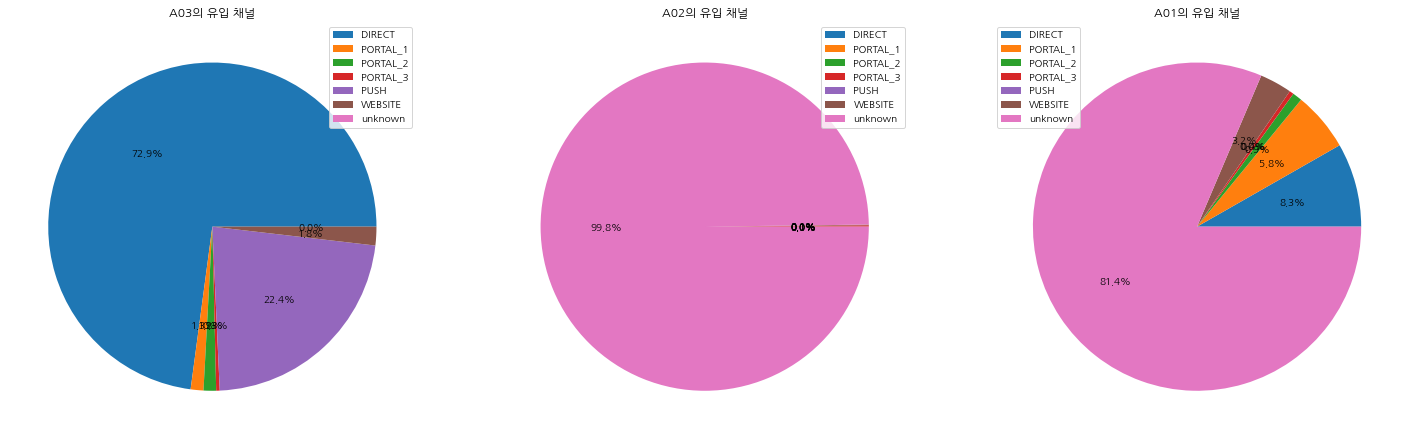

In [172]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))
labels = ['DIRECT', 'PORTAL_1', 'PORTAL_2', 'PORTAL_3', 'PUSH', 'WEBSITE', 'unknown']

axs[0].pie(online_A03['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[0].legend(labels)
axs[0].set_title('A03의 유입 채널')

axs[1].pie(online_A02['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[1].legend(labels)
axs[1].set_title('A02의 유입 채널')

axs[2].pie(online_A01['trfc_src'].value_counts().sort_index(), autopct='%0.1f%%')
axs[2].legend(labels)
axs[2].set_title('A01의 유입 채널')

plt.show()

### 1-14. dvc_ctg_nm : 기기 유형 

 * mobile_web / mobile_app / PC

 * 기기유형의 종류는 몇 개나 있는가?? => 3개

In [173]:
raw_data1_Online_Act['dvc_ctg_nm'].nunique()

4

 * 기기유형 별 온라인 행동데이터는 몇 건이 있는지? => 최대 67.0만건 , 최소 26.5만건
 
     * 모바일 114만 건 / PC 26만건


In [174]:
raw_data1_Online_Act['dvc_ctg_nm'].value_counts()

unknown       1782577
mobile_web     672936
mobile_app     474859
PC             265990
Name: dvc_ctg_nm, dtype: int64

In [236]:
online_A03['dvc_ctg_nm'].value_counts().sort_index()

PC             150421
mobile_web     398935
unknown       1782081
Name: dvc_ctg_nm, dtype: int64

 * 결측치 갯수 확인 => 178만 건

In [175]:
raw_data1_Online_Act['dvc_ctg_nm'].isna().sum()

0

unknown 문제 발생

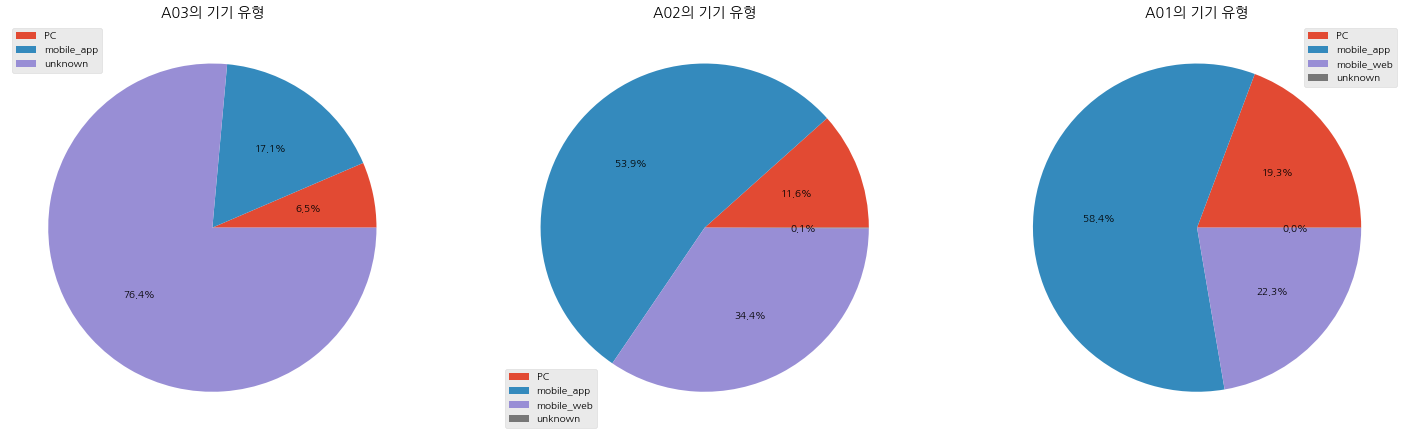

In [237]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))
labels1 = ['PC', 'mobile_app', 'unknown']
labels = ['PC', 'mobile_app', 'mobile_web', 'unknown']

axs[0].pie(online_A03['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[0].legend(labels1)
axs[0].set_title('A03의 기기 유형')

axs[1].pie(online_A02['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[1].legend(labels)
axs[1].set_title('A02의 기기 유형')

axs[2].pie(online_A01['dvc_ctg_nm'].value_counts().sort_index(), autopct='%0.1f%%')
axs[2].legend(labels)
axs[2].set_title('A01의 기기 유형')

plt.show()

## 2. 거래 정보 데이터 확인

In [177]:
raw_data2_Trade_Inform.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
0,2,42449.0,1,A02,1015.0,20190704,15:34,46430,1
1,2,62037.0,1,A03,92.0,20190729,23:47,36000,20
2,2,64691.0,1,A03,186.0,20190731,21:25,3790,1
3,2,64691.0,2,A03,151.0,20190731,21:25,3990,1
4,2,64691.0,3,A03,351.0,20190731,21:25,4690,1


 * 2-1(=1-1, 3-1). clnt_id : 고객 고유 식별 ID
 * 2-2(=1-9). trans_ID : 거래 ID(구매내역을 고유 식별할 수 있는 ID)
 * 2-3. trans_seq : 구매 내역 내 구매 순서를 알 수 있도록 한 일련번호
 * 2-4(=1-5). biz_unit(업종단위) : 온라인 및 오프라인 이용코드
 * 2-5(=4-1). pd_c : 상품의 소분류 코드
 * 2-6. de_dt : 구매일자(년월일)
 * 2-7. de_tm : 구매시각(HHMM)
 * 2-8. buy_am : 구매금액
 * 2-9. buy_ct : 구매수량

In [178]:
raw_data2_Trade_Inform.shape

(599961, 9)

 * 행 수(데이터 갯수) : 59.9만 개
 * 열 수(데이터 종류) : 9개

### 2-1. clnt_id : 고객 고유 식별 ID

 * 1-1, 3-1 clnt_id와 동일 의미

 * 거래정보데이터 내 고객ID의 종류는 몇 개나 있는가?? => 11284개
     * 1. 온라인 행동 데이터 내 고객ID 갯수 : 72399개
     * 2. 거래 정보 데이터 내 고객ID 갯수 :11284개
     * 3. 사용자 demog 정보 내 고객ID 갯수 : 72399개

In [179]:
raw_data2_Trade_Inform['clnt_id'].nunique()

11284

 * 고객ID 별 거래정보데이터는 몇 건이 있는지? => 최대 757건 , 최소 1건 

In [180]:
raw_data2_Trade_Inform['clnt_id'].value_counts()

27221    757
42575    681
52362    623
71243    579
12198    565
        ... 
32432      1
35025      1
27340      1
52443      1
14343      1
Name: clnt_id, Length: 11284, dtype: int64

 * 결측치 갯수 확인 => 없음

In [181]:
raw_data2_Trade_Inform['clnt_id'].isna().sum()

0

### 2-2. trans_id : 거래 ID(구매내역을 고유 식별할 수 있는 ID)

 * 1-9 trans_id와 동일 의미

 * 거래정보데이터 내 거래ID의 종류는 몇 개나 있는가?? => 11만개
     * 1. 온라인 행동 데이터 내 거래ID 갯수 : 50997개
     * 2. 거래 정보 데이터 내 거래ID 갯수 : 116440개

In [182]:
raw_data2_Trade_Inform['trans_id'].nunique()

116440

 * 거래ID 별 거래정보데이터는 몇 건이 있는지? => 최대 105건 , 최소 1건 

In [183]:
raw_data2_Trade_Inform['trans_id'].value_counts()

132554.0    105
51589.0     100
102723.0     72
132637.0     72
137451.0     65
           ... 
48974.0       1
43896.0       1
48972.0       1
73503.0       1
44198.0       1
Name: trans_id, Length: 116440, dtype: int64

 * 결측치 갯수 확인 => 없음

In [184]:
raw_data2_Trade_Inform['trans_id'].isna().sum()

0

### 2-3. trans_seq : 구매 내역 내 구매 순서를 알 수 있도록 한 일련번호

 * 거래정보데이터 내 구매일련번호의 종류는 몇 개나 있는가?? => 105개

In [185]:
raw_data2_Trade_Inform['trans_seq'].nunique()

105

 * 구매일련번호 별 거래정보데이터는 몇 건이 있는지? => 최대 11만건 , 최소 1건 

In [186]:
raw_data2_Trade_Inform['trans_seq'].value_counts()

1      116440
2       80693
3       66071
4       56049
5       48138
        ...  
102         1
103         1
104         1
101         1
105         1
Name: trans_seq, Length: 105, dtype: int64

 * 결측치 갯수 확인 => 없음

In [187]:
raw_data2_Trade_Inform['trans_seq'].isna().sum()

0

### 2-4. biz_unit(업종단위) : 온라인 및 오프라인 이용코드

 * 1-5. biz_unit 데이터와 의미 동일

 * 거래정보데이터 내 업종단위의 종류는 몇 개나 있는가?? => 6개
     * 1. 온라인 행동 데이터 내 업종단위 갯수 : 3개 (A01, A02, A03)
     * 2. 거래 정보 데이터 내 업종단위 갯수 : 6개 (A01, A02, A03, B01, B02, B03)

In [188]:
raw_data2_Trade_Inform['biz_unit'].nunique()

6

 * 업종단위 별 거래정보데이터는 몇 건이 있는지? => 최대 20만건 , 최소 3000건 

In [189]:
raw_data2_Trade_Inform['biz_unit'].value_counts()

A03    201982
B01    200781
B02    168803
A02     19850
A01      5126
B03      3419
Name: biz_unit, dtype: int64

 * 결측치 갯수 확인 => 없음

In [190]:
raw_data2_Trade_Inform['biz_unit'].isna().sum()

0

### 2-5. pd_c : 상품의 소분류 코드

 * 4-1. pd_c 데이터와 의미 동일

 * 거래정보데이터 내 소분류 코드의 종류는 몇 개나 있는가?? => 1668개
     * 2. 거래 정보 데이터 내 소분류 갯수 : 1668개
     * 4. 상품 대중소 분류 데이터 내 소분류 갯수 : 1667개
     * 1개 차이는 'unknown' 유무로 예상

In [191]:
raw_data2_Trade_Inform['pd_c'].nunique()

1667

 * 소분류코드 별 거래정보데이터는 몇 건이 있는지? => 최대 1.5만건 , 최소 1건 

In [192]:
raw_data2_Trade_Inform['pd_c'].value_counts()

1213.0    15518
347.0     12914
964.0     11115
1395.0    11083
1617.0    10850
          ...  
1146.0        1
1541.0        1
778.0         1
773.0         1
1318.0        1
Name: pd_c, Length: 1667, dtype: int64

 * 결측치 갯수 확인 => 17652개 (unknown)

### 2-6. de_dt : 구매일자(년월일)

 * 구매 일자는 몇 개나 있는가?? => 92개
     * 3달치 데이터가 날짜마다 있을 것을 예상됨
         * 7,8,9월 일자 = 31 + 31 + 30 = 92
         
 * 1. 온라인 행동 정보 데이터 내 '1-6. sess_dt 세션일자'와 연관 지을수 있음

In [193]:
raw_data2_Trade_Inform['de_dt'].nunique()

92

 * 구매일자 별 거래정보데이터는 몇 건이 있는지? => 최대 9357건 , 최소 1979건

In [194]:
raw_data2_Trade_Inform['de_dt'].value_counts()

20190911    9357
20190713    8707
20190720    8658
20190727    8603
20190921    8467
            ... 
20190922    3042
20190811    2806
20190728    2705
20190825    2462
20190913    1979
Name: de_dt, Length: 92, dtype: int64

 * 결측치 갯수 확인 => 없음

In [195]:
raw_data2_Trade_Inform['de_dt'].isna().sum()

0

### 2-7. de_tm : 구매시각(HHMM)

 * 구매 시각는 몇 개나 있는가?? => 1436개

In [196]:
raw_data2_Trade_Inform['de_tm'].nunique()

1436

 * 구매시각 거래정보데이터는 몇 건이 있는지? => 최대 1094건 , 최소 1건

In [197]:
raw_data2_Trade_Inform['de_tm'].value_counts()

16:17    1094
18:03    1033
17:11    1012
17:27     992
17:18     985
         ... 
04:29       1
04:31       1
03:27       1
05:00       1
05:12       1
Name: de_tm, Length: 1436, dtype: int64

 * 결측치 갯수 확인 => 없음

In [198]:
raw_data2_Trade_Inform['de_tm'].isna().sum()

0

### 2-8. buy_am : 구매금액

 * 구매 금액은 몇 개나 있는가?? => 14810개

In [199]:
raw_data2_Trade_Inform['buy_am'].nunique()

14810

 * 구매금액 별 거래정보데이터는 몇 건이 있는지? => 최대 1.8만건 , 최소 1건

In [200]:
raw_data2_Trade_Inform['buy_am'].value_counts()

2990     18064
1000     16200
1990     15745
3990     14652
990      14087
         ...  
2235         1
12476        1
8382         1
10431        1
4094         1
Name: buy_am, Length: 14810, dtype: int64

 * 결측치 갯수 확인 => 최소 금액 0

In [201]:
raw_data2_Trade_Inform['buy_am'].isna().sum()

0

 * 최대 금액은?? => 1천억

In [202]:
max(raw_data2_Trade_Inform['buy_am'])

100000016899

 * 최소금액은?? => 0

In [203]:
min(raw_data2_Trade_Inform['buy_am'])

0

### 2-9. buy_ct : 구매 수량

 * 구매수량은 몇 종류나 있는가?? => 338개

In [204]:
raw_data2_Trade_Inform['buy_ct'].nunique()

338

 * 구매수량 별 거래정보데이터는 몇 건이 있는지? => 최대 49만건 , 최소 1건

In [205]:
raw_data2_Trade_Inform['buy_ct'].value_counts()

1      497831
2       62837
3       12371
0        6775
4        6377
        ...  
210         1
207         1
717         1
204         1
155         1
Name: buy_ct, Length: 338, dtype: int64

 * NaN 갯수 확인 => 없음
     * 위 최소 수량 0을 결측치로 고려 => 6775개

In [206]:
raw_data2_Trade_Inform['buy_ct'].isna().sum()

0

 * 최대 수량은?? => 3600개

In [207]:
max(raw_data2_Trade_Inform['buy_ct'])

3600

 * 최소 수량은?? => 0
     * 결측치로 고려

In [208]:
min(raw_data2_Trade_Inform['buy_ct'])

0

 ## 3. 사용자 demo 정보(나이, 성별) 확인

In [209]:
raw_data3_Demog.head()

,clnt_id,clnt_gender,clnt_age
0,1,NaN,NaN
1,2,F,30.0
2,3,NaN,NaN
3,4,NaN,NaN
4,5,NaN,NaN


 * 3-1(=2-1, 1-1). clnt_id : 고객 고유 식별 ID
 * 3-2. clnt_gender : 고객 성별
 * 3-3. clnt_age : 고객 연령대( 10단위:  10대 이하 / 20대 / 30대 / 40대 / 50대 / 60대 / unknown)

In [210]:
raw_data3_Demog.shape

(72399, 3)

 * 행 수(데이터 갯수) : 7.2만 개
 * 열 수(데이터 종류) : 3개

In [211]:
raw_data3_Demog['clnt_gender'].value_counts().sort_index()

F    10352
M     1893
Name: clnt_gender, dtype: int64

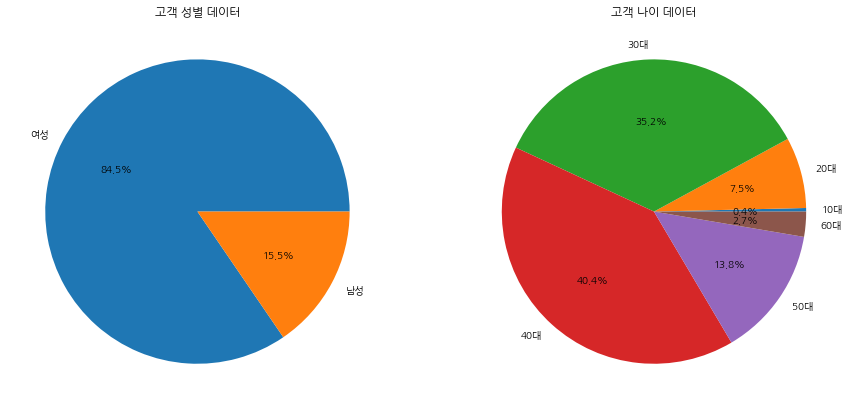

In [212]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
label_gender = ['여성', '남성']
label_age = ['10대', '20대', '30대', '40대', '50대', '60대']

axs[0].pie(raw_data3_Demog['clnt_gender'].value_counts().sort_index(), autopct='%0.1f%%', labels=label_gender)
axs[0].set_title('고객 성별 데이터')

axs[1].pie(raw_data3_Demog['clnt_age'].value_counts().sort_index(), autopct='%0.1f%%', labels=label_age)
axs[1].set_title('고객 나이 데이터')

plt.show()


### 3-1. clnt_Id : 고객 고유 식별 ID

 * 1-1, 2-1 clnt_id와 동일 의미

 * 고객 ID는 몇 개나 있는가?? => 7만명의 고객 ID 보유
     * 1. 온라인 행동 데이터 내 고객ID 갯수 : 72399개
     * 2. 거래 정보 데이터 내 고객ID 갯수 :11284개
     * 3. 사용자 demog 정보 내 고객ID 갯수 : 72399개

In [213]:
raw_data3_Demog['clnt_id'].nunique()

72399

 * 고객ID 별로 사용자 demog 데이터는 몇 건이 있는지? => 1건
     * 서로 다른 사람이 같은 ID를 공유하는 오류데이터는 없음

In [214]:
raw_data3_Demog['clnt_id'].value_counts()

2047     1
27288    1
14994    1
12947    1
2708     1
        ..
25958    1
32101    1
30052    1
19811    1
2049     1
Name: clnt_id, Length: 72399, dtype: int64

 * 결측치 갯수 확인 => 없음

In [215]:
raw_data3_Demog['clnt_id'].isna().sum()

0

In [216]:
raw_data3_Demog.head()

,clnt_id,clnt_gender,clnt_age
0,1,NaN,NaN
1,2,F,30.0
2,3,NaN,NaN
3,4,NaN,NaN
4,5,NaN,NaN


### 3-2. clnt_gender : 고객 성별

 * 성별은 몇 개나 있는가?? => 3개 (남, 여, 알수 없음)

In [217]:
raw_data3_Demog['clnt_gender'].nunique()

2

 * 성별 별로 사용자 demog 데이터는 몇 건이 있는지? => 알 수없음 6만, 여성 1만, 남성 1800

In [218]:
raw_data3_Demog['clnt_gender'].value_counts()

F    10352
M     1893
Name: clnt_gender, dtype: int64

 * 결측치 갯수 확인 => 60154개

### 3-3. clnt_age : 고객 연령대

 * 10단위: 10대 이하 / 20대 / 30대 / 40대 / 50대 / 60대 / unknown

 * 연령대는 몇 종류나 있는가?? => 7종

In [219]:
raw_data3_Demog['clnt_age'].nunique()

6

 * 연령 별로 사용자 demog 데이터는 몇 건이 있는지?
 
     * 10대 : 46
     * 20대 : 924
     * 30대 : 4307
     * 40대 : 4948
     * 50대 : 1694
     * 60대 : 326
     * 알 수 없음 : 60154

In [220]:
raw_data3_Demog['clnt_age'].value_counts()

40.0    4948
30.0    4307
50.0    1694
20.0     924
60.0     326
10.0      46
Name: clnt_age, dtype: int64

 * 결측치 갯수 확인 => 60154개

## 4. 상품 대중소 분류 정보

In [221]:
raw_data4_Item_Class.head()

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,1.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,2.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,3.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,4.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,5.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades


* 4-1. pd_c : 상품 소분류 코드
* 4-2. clac_nm1 : 상품 대분류명
* 4-3. clac_nm2 : 상품 중분류명
* 4-4. clac_nm3 : 상품 소분류명

In [222]:
raw_data4_Item_Class.shape

(1667, 4)

 * 행 수(데이터 갯수) : 1667개
 * 열 수(데이터 종류) : 4개

### 4-1. pd_c : 상품의 소분류 코드

 * 2-5. pd_c 데이터와 의미 동일

 * 상품분류데이터 내 소분류 코드의 종류는 몇 개나 있는가?? => 1667개
     * 2. 거래 정보 데이터 내 소분류 갯수 : 1668개
     * 4. 상품 대중소 분류 데이터 내 소분류 갯수 : 1667개
     * 1개 차이는 'unknown' 유무로 예상

In [223]:
raw_data4_Item_Class['pd_c'].nunique()

1667

 * 소분류코드 별 상품분류데이터는 몇 건이 있는지? => 각 1건

In [224]:
raw_data4_Item_Class['pd_c'].value_counts()

887.0     1
1478.0    1
1266.0    1
903.0     1
1400.0    1
         ..
798.0     1
1126.0    1
1550.0    1
35.0      1
75.0      1
Name: pd_c, Length: 1667, dtype: int64

 * 결측치 갯수 확인 => 없음

In [225]:
raw_data4_Item_Class['pd_c'].isna().sum()

0

### 4-2. clac_nm1 : 상품 대분류명

 * 상품분류데이터 내 대분류명의 종류는 몇 개나 있는가?? => 60개

In [226]:
raw_data4_Item_Class['clac_nm1'].nunique()

60

 * 대분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 100건, 최소 1건

In [227]:
raw_data4_Item_Class['clac_nm1'].value_counts()

Fashion Accessories                          100
Meats                                         80
Sea Foods                                     76
Vegetables                                    70
Kids' Clothing                                67
Stationary / Office Supplies                  61
Fruits                                        56
Underwear / Socks and Hosiery / Homewear      53
Sport Fashion                                 52
Spices / Seasonings                           49
Cosmetics / Beauty Care                       48
Personal Care                                 38
Snack Foods                                   36
Cooked Foods                                  35
Tableware / Cooking Utensils                  35
Gardening / Pets                              35
Home / Kitchen Appliances                     33
Chilled Foods                                 32
Cleaning / Laundry / Bathroom Accessories     30
Bedding / Handicraft                          30
Kitchenware         

 * 결측치 갯수 확인 => 없음

In [228]:
raw_data4_Item_Class['clac_nm1'].isna().sum()

0

### 4-3. clac_nm2 : 상품 중분류명

 * 상품분류데이터 내 중분류명의 종류는 몇 개나 있는가?? => 332개

In [229]:
raw_data4_Item_Class['clac_nm2'].nunique()

332

 * 중분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 19건, 최소 1건

In [230]:
raw_data4_Item_Class['clac_nm2'].value_counts()

Fish                          19
Kitchen Appliances            17
Imported Fruits               16
Leaf Vegetables               16
Domestic Fruits               16
                              ..
Non-Prescription Medicines     1
Income from leasing            1
Special Cigarettes             1
Soy Milk                       1
Outdoor Furniture              1
Name: clac_nm2, Length: 332, dtype: int64

 * 결측치 갯수 확인 => 없음

In [231]:
raw_data4_Item_Class['clac_nm2'].isna().sum()

0

### 4-4. clac_nm3 : 상품 소분류명

 * 상품분류데이터 내 소분류명의 종류는 몇 개나 있는가?? => 1662개
     * 4-1. 소분류코드 종류 갯수 : 1667개
     * 1662 + 3(같은이름 다른코드) + 2(결측치) = 1667

In [232]:
raw_data4_Item_Class['clac_nm3'].nunique()

1662

 * 소분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 2건, 최소 1건
     * 같은 상품 이름에 서로다른 소분류 코드 존재(Salads, Peppers, Lunch Boxes)

In [233]:
raw_data4_Item_Class['clac_nm3'].value_counts()

Salads                               2
Peppers                              2
Lunch Boxes                          2
Domestic Travel Packages             1
Pineapples                           1
                                    ..
Soccer Socks and Hosiery             1
Seasoned Beefs                       1
Frozen Hotdogs                       1
Functional Cereals                   1
Cooked Greens / Namuls / Pancakes    1
Name: clac_nm3, Length: 1662, dtype: int64

 * 결측치 갯수 확인 => 2개

In [234]:
raw_data4_Item_Class['clac_nm3'].isna().sum()

2

* 시각화 예시 - 막대 그래프

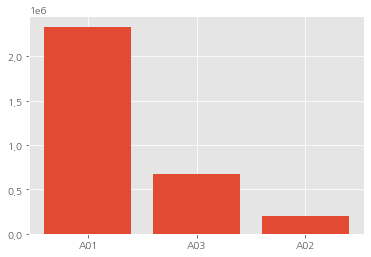

In [235]:
plt.style.use('ggplot')

fig = plt.figure()

ax = fig.add_subplot()
ax.bar(raw_data1_Online_Act['biz_unit'].unique(), raw_data1_Online_Act['biz_unit'].value_counts())

plt.show()